Saving vmCloud_data1.csv to vmCloud_data1 (3).csv
Dataset Preview:
                                  vm_id         timestamp  cpu_usage  \
0  c5215826-6237-4a33-9312-72c1df909881  25-01-2023 09:10  54.881350   
1  29690bc6-1f34-403b-b509-a1ecb1834fb8  26-01-2023 04:46  71.518937   
2  2e55abc3-5bad-46cb-b445-a577f5e9bf2a  13-01-2023 23:39        NaN   
3  e672e32f-c134-4fbc-992b-34eb63bef6bf  09-02-2023 11:45  54.488318   
4  f38b8b50-6926-4533-be4f-89ad11624071  14-06-2023 08:27  42.365480   

   memory_usage  network_traffic  power_consumption  \
0     78.950861       164.775973         287.808986   
1     29.901883              NaN         362.273569   
2     92.709195       203.674847         231.467903   
3     88.100960              NaN         195.639954   
4           NaN              NaN         359.451537   

   num_executed_instructions  execution_time  energy_efficiency task_type  \
0                     7527.0       69.345575           0.553589   network   
1              

<ipython-input-13-980f64863dd1>:27: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df_selected.fillna(method='ffill', inplace=True)
<ipython-input-13-980f64863dd1>:27: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_selected.fillna(method='ffill', inplace=True)


<Figure size 1500x600 with 0 Axes>

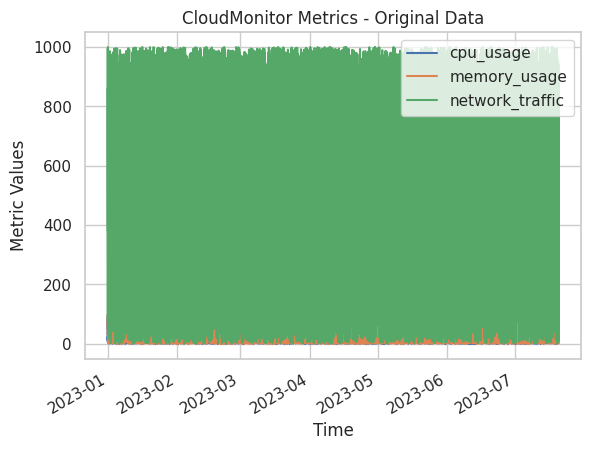

Anomalies detected:
Empty DataFrame
Columns: [cpu_usage, memory_usage, network_traffic]
Index: []


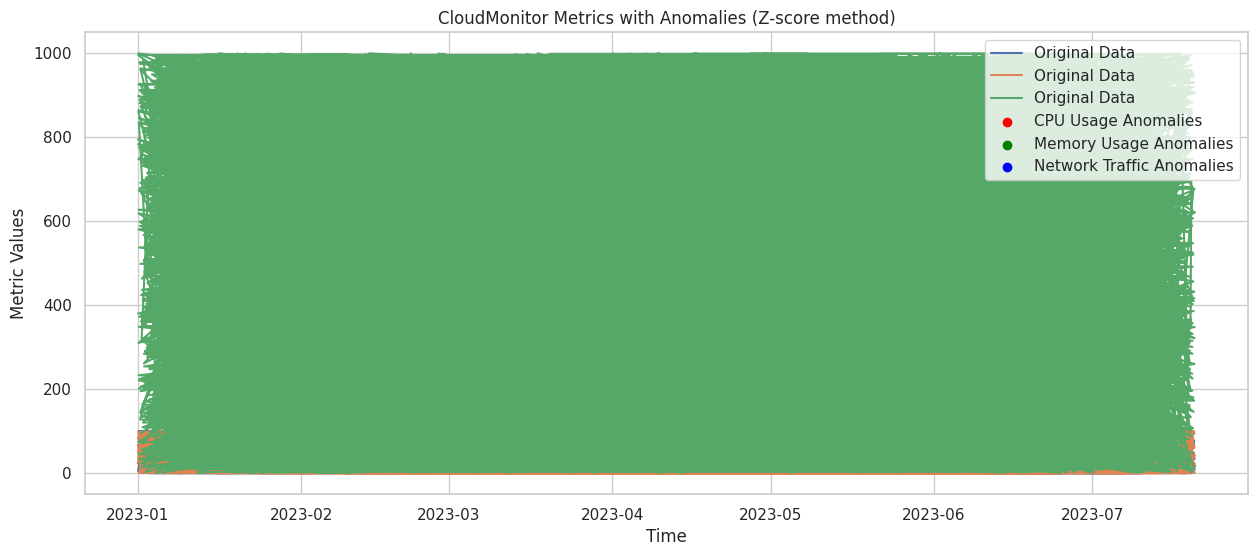

In [13]:
!pip install pandas numpy matplotlib seaborn scipy

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats

from google.colab import files
uploaded = files.upload()

import io
csv_file_name = list(uploaded.keys())[0]
df = pd.read_csv(io.BytesIO(uploaded[csv_file_name]))

print("Dataset Preview:")
print(df.head())

df['timestamp'] = pd.to_datetime(df['timestamp'], dayfirst=True, errors='coerce')

df.dropna(subset=['timestamp'], inplace=True)

df.set_index('timestamp', inplace=True)

df_selected = df[['cpu_usage', 'memory_usage', 'network_traffic']]

df_selected.fillna(method='ffill', inplace=True)

plt.figure(figsize=(15,6))
df_selected.plot()
plt.title('CloudMonitor Metrics - Original Data')
plt.xlabel('Time')
plt.ylabel('Metric Values')
plt.show()

z_threshold = 3

z_scores = np.abs(stats.zscore(df_selected))

anomalies = (z_scores > z_threshold)

df_anomalies = df_selected[anomalies.any(axis=1)]
print("Anomalies detected:")
print(df_anomalies)

plt.figure(figsize=(15,6))
plt.plot(df_selected, label='Original Data')
plt.scatter(df_anomalies.index, df_anomalies['cpu_usage'], color='red', label='CPU Usage Anomalies')
plt.scatter(df_anomalies.index, df_anomalies['memory_usage'], color='green', label='Memory Usage Anomalies')
plt.scatter(df_anomalies.index, df_anomalies['network_traffic'], color='blue', label='Network Traffic Anomalies')
plt.title('CloudMonitor Metrics with Anomalies (Z-score method)')
plt.xlabel('Time')
plt.ylabel('Metric Values')
plt.legend()
plt.show()


Categorized Anomalies:
Empty DataFrame
Columns: [cpu_usage, cpu_usage_category, memory_usage, memory_usage_category, network_traffic, network_traffic_category]
Index: []


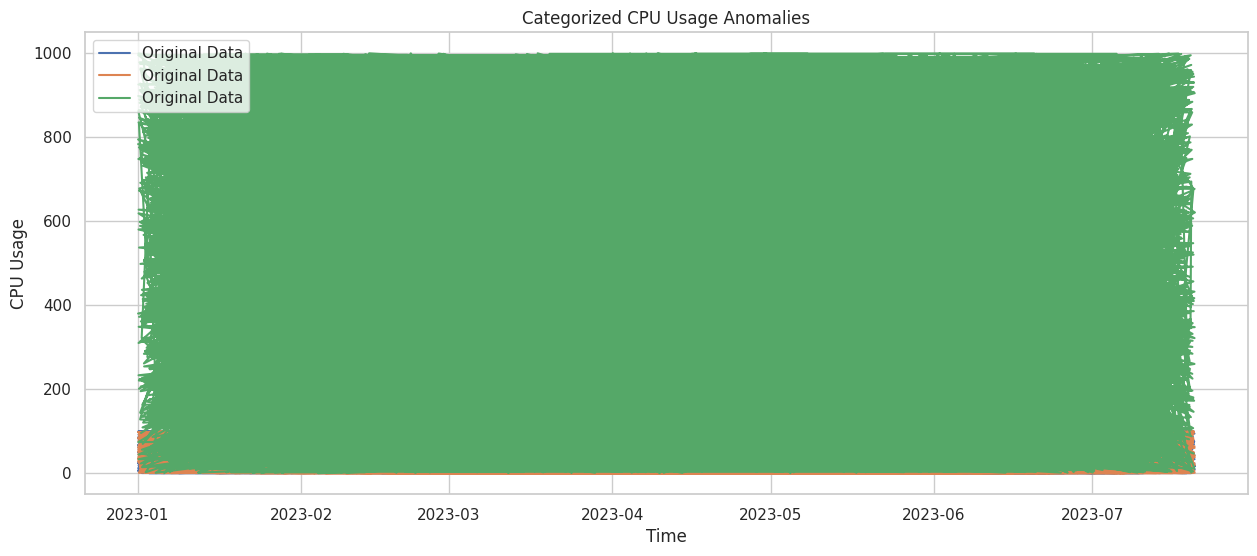

In [14]:
def categorize_anomaly(row, prev_row):
    if row is None or prev_row is None:
        return None
    diff = row - prev_row
    if diff > 0 and abs(diff) > row.std() * 2:
        return 'Spike'
    elif diff < 0 and abs(diff) > row.std() * 2:
        return 'Sudden Drop'
    elif abs(diff) < row.std() * 0.1:
        return 'Gradual Drift'
    else:
        return 'Unclassified'

df_anomalies['cpu_usage_category'] = df_anomalies['cpu_usage'].diff().apply(lambda x: categorize_anomaly(x, df_anomalies['cpu_usage'].mean()))
df_anomalies['memory_usage_category'] = df_anomalies['memory_usage'].diff().apply(lambda x: categorize_anomaly(x, df_anomalies['memory_usage'].mean()))
df_anomalies['network_traffic_category'] = df_anomalies['network_traffic'].diff().apply(lambda x: categorize_anomaly(x, df_anomalies['network_traffic'].mean()))

print("Categorized Anomalies:")
print(df_anomalies[['cpu_usage', 'cpu_usage_category', 'memory_usage', 'memory_usage_category', 'network_traffic', 'network_traffic_category']])

plt.figure(figsize=(15,6))
plt.plot(df_selected, label='Original Data')

colors = {'Spike': 'red', 'Sudden Drop': 'blue', 'Gradual Drift': 'green', 'Unclassified': 'gray'}
for category in df_anomalies['cpu_usage_category'].unique():
    if category:
        plt.scatter(df_anomalies[df_anomalies['cpu_usage_category'] == category].index,
                    df_anomalies[df_anomalies['cpu_usage_category'] == category]['cpu_usage'],
                    color=colors[category], label=f'CPU Usage - {category}')

plt.title('Categorized CPU Usage Anomalies')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.legend()
plt.show()

Anomalies with Severity Scores:
Empty DataFrame
Columns: [cpu_usage, cpu_usage_category, severity_score, memory_usage, memory_usage_category, network_traffic, network_traffic_category]
Index: []


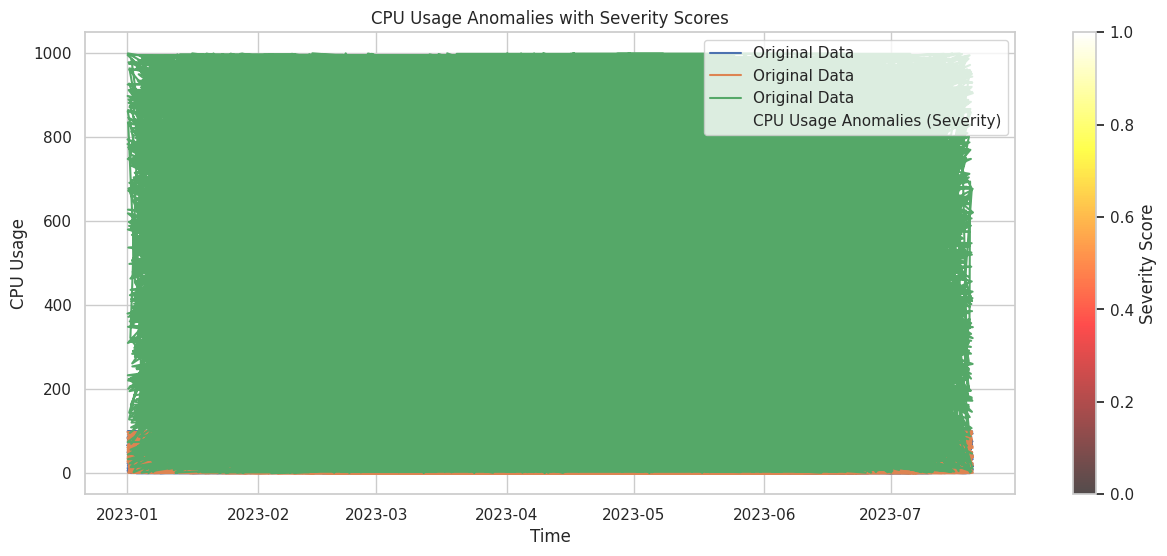

In [15]:
def calculate_severity_score(df, metric, threshold=3):

    df['magnitude'] = (df[metric] - df[metric].mean()).abs()

    df['duration'] = (df.index.to_series().diff().fillna(pd.Timedelta(seconds=0)).dt.total_seconds() / 3600).fillna(0)

    df['severity_score'] = (df['magnitude'] * 0.5) + (df['duration'] * 0.3) + (df['magnitude'] / (df['duration'] + 1) * 0.2)

    return df

df_anomalies = calculate_severity_score(df_anomalies, 'cpu_usage')
df_anomalies = calculate_severity_score(df_anomalies, 'memory_usage')
df_anomalies = calculate_severity_score(df_anomalies, 'network_traffic')

print("Anomalies with Severity Scores:")
print(df_anomalies[['cpu_usage', 'cpu_usage_category', 'severity_score', 'memory_usage', 'memory_usage_category', 'network_traffic', 'network_traffic_category']])

plt.figure(figsize=(15,6))
plt.plot(df_selected, label='Original Data')

plt.scatter(df_anomalies.index, df_anomalies['cpu_usage'],
            c=df_anomalies['severity_score'], cmap='hot',
            label='CPU Usage Anomalies (Severity)', alpha=0.7)

plt.title('CPU Usage Anomalies with Severity Scores')
plt.xlabel('Time')
plt.ylabel('CPU Usage')
plt.colorbar(label='Severity Score')
plt.legend()
plt.show()



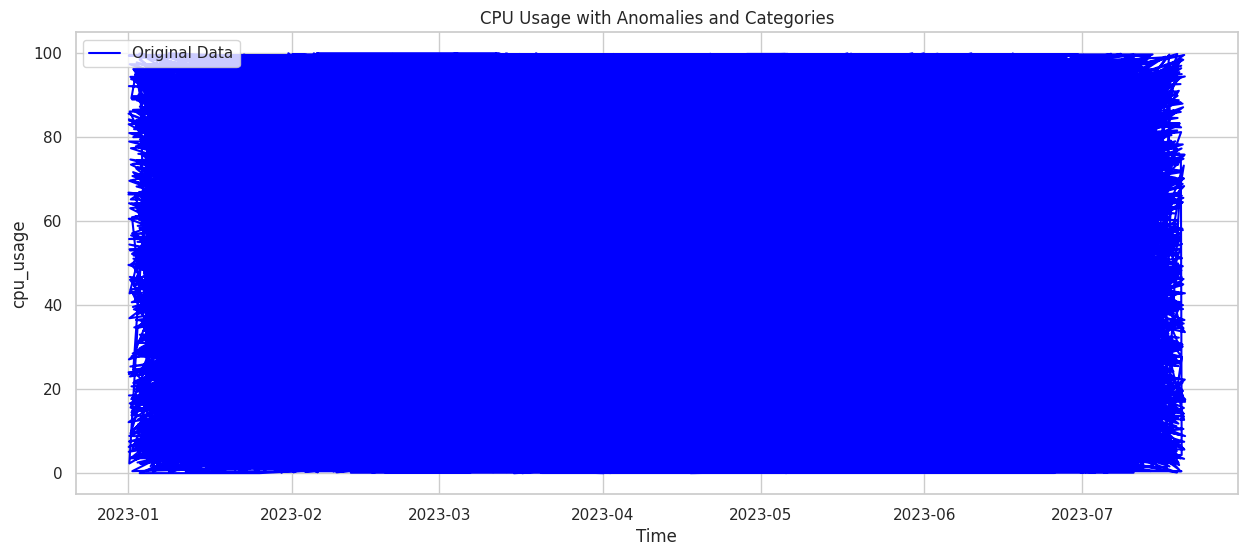

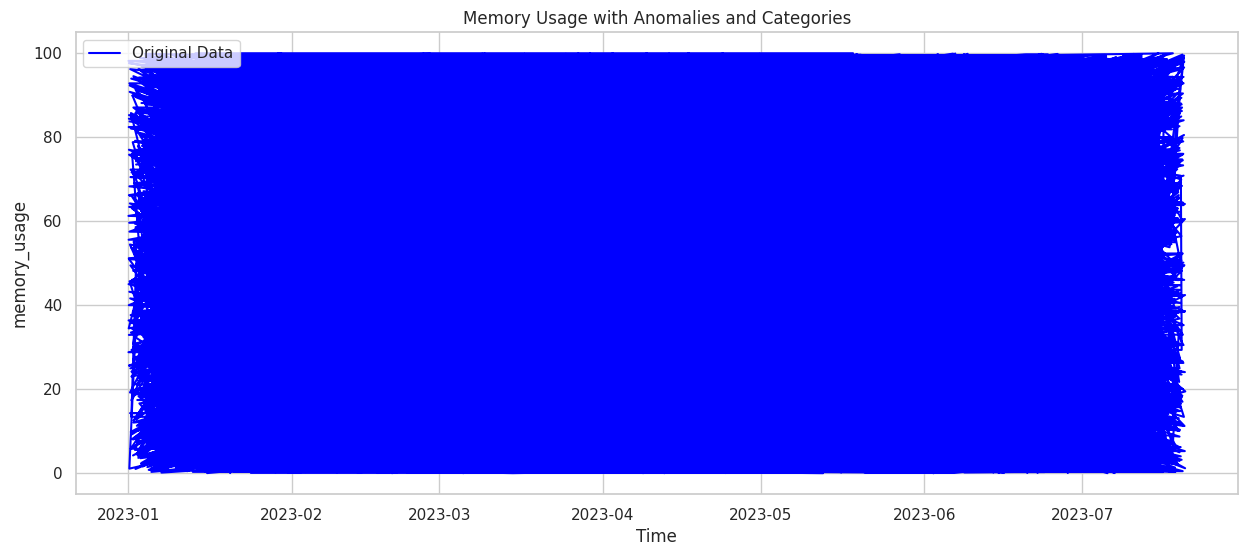

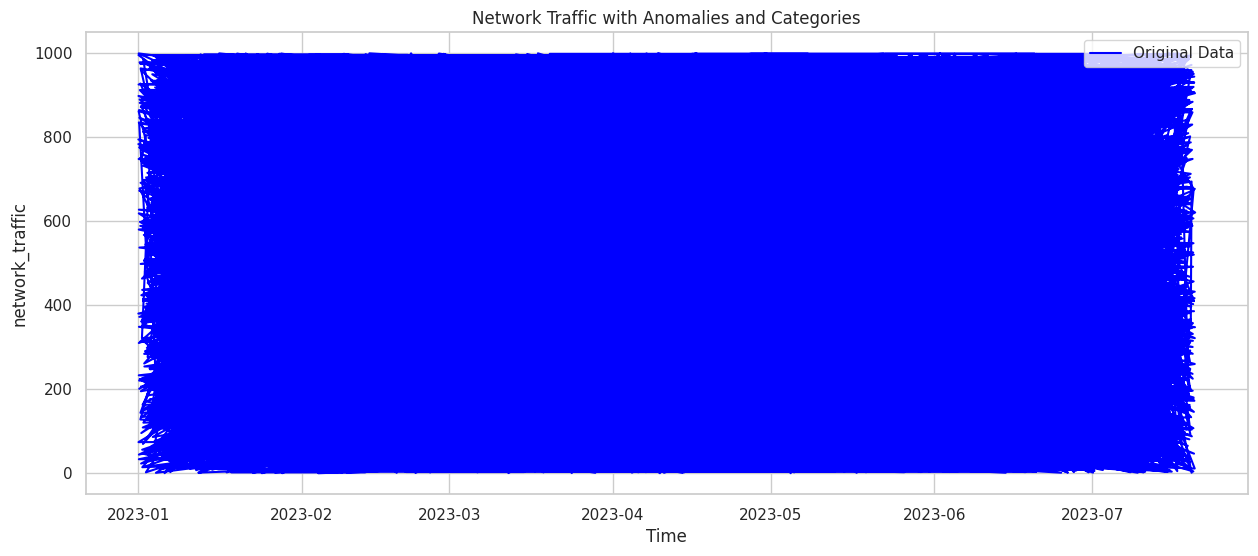

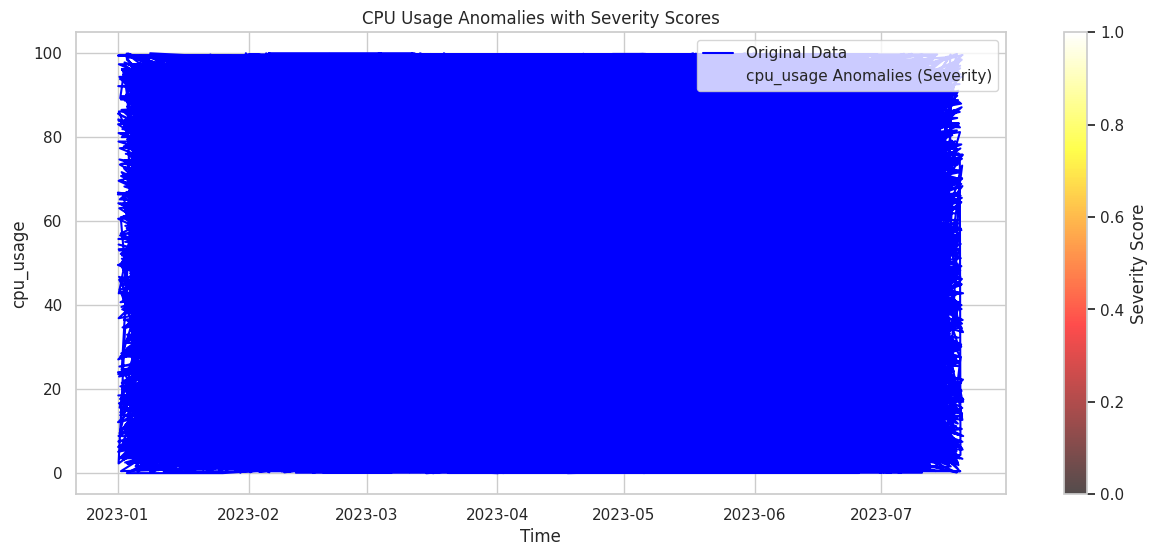

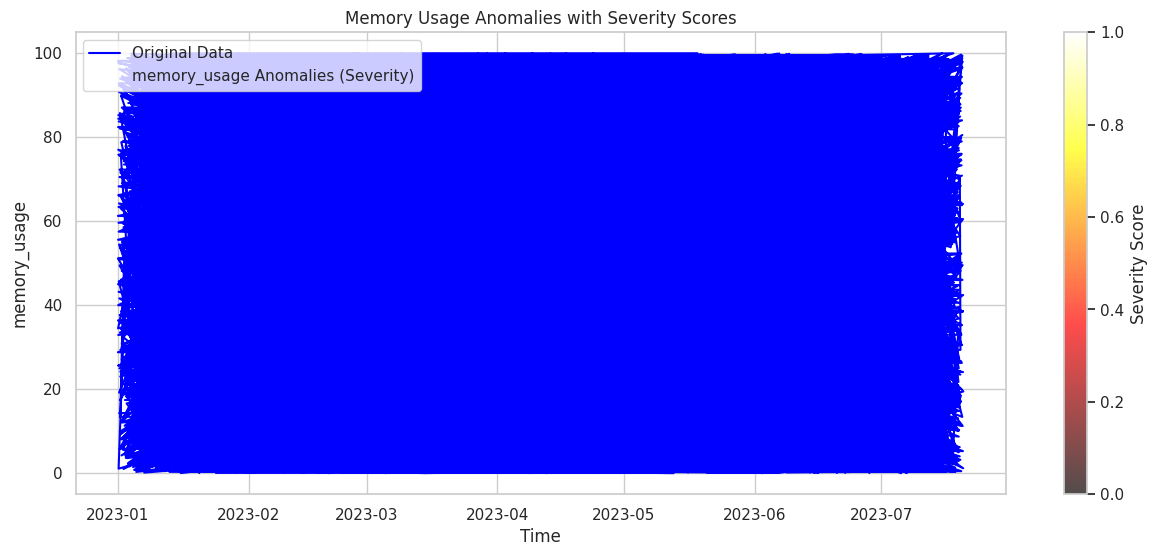

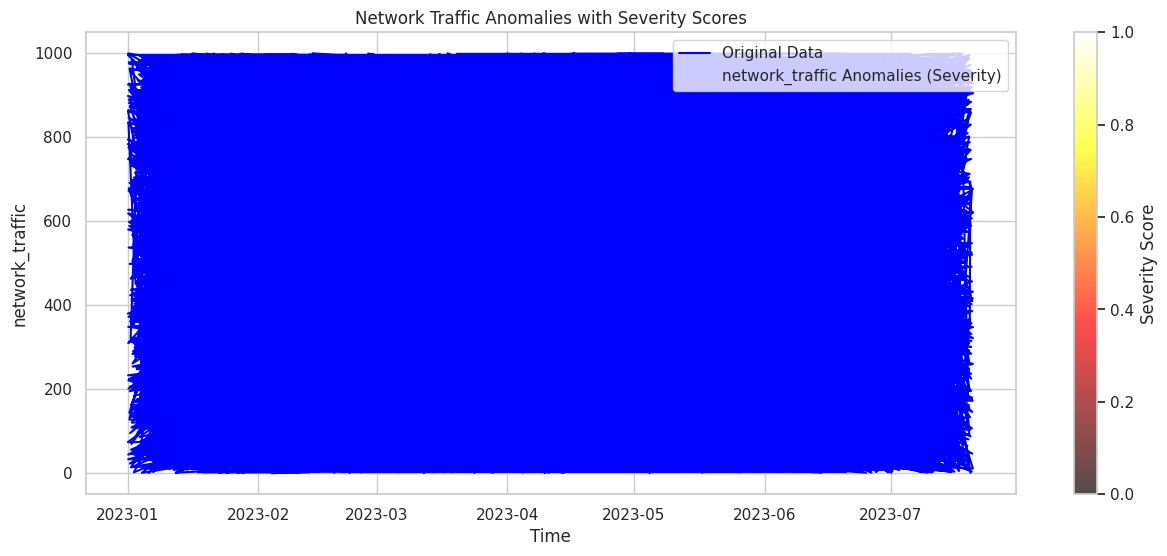

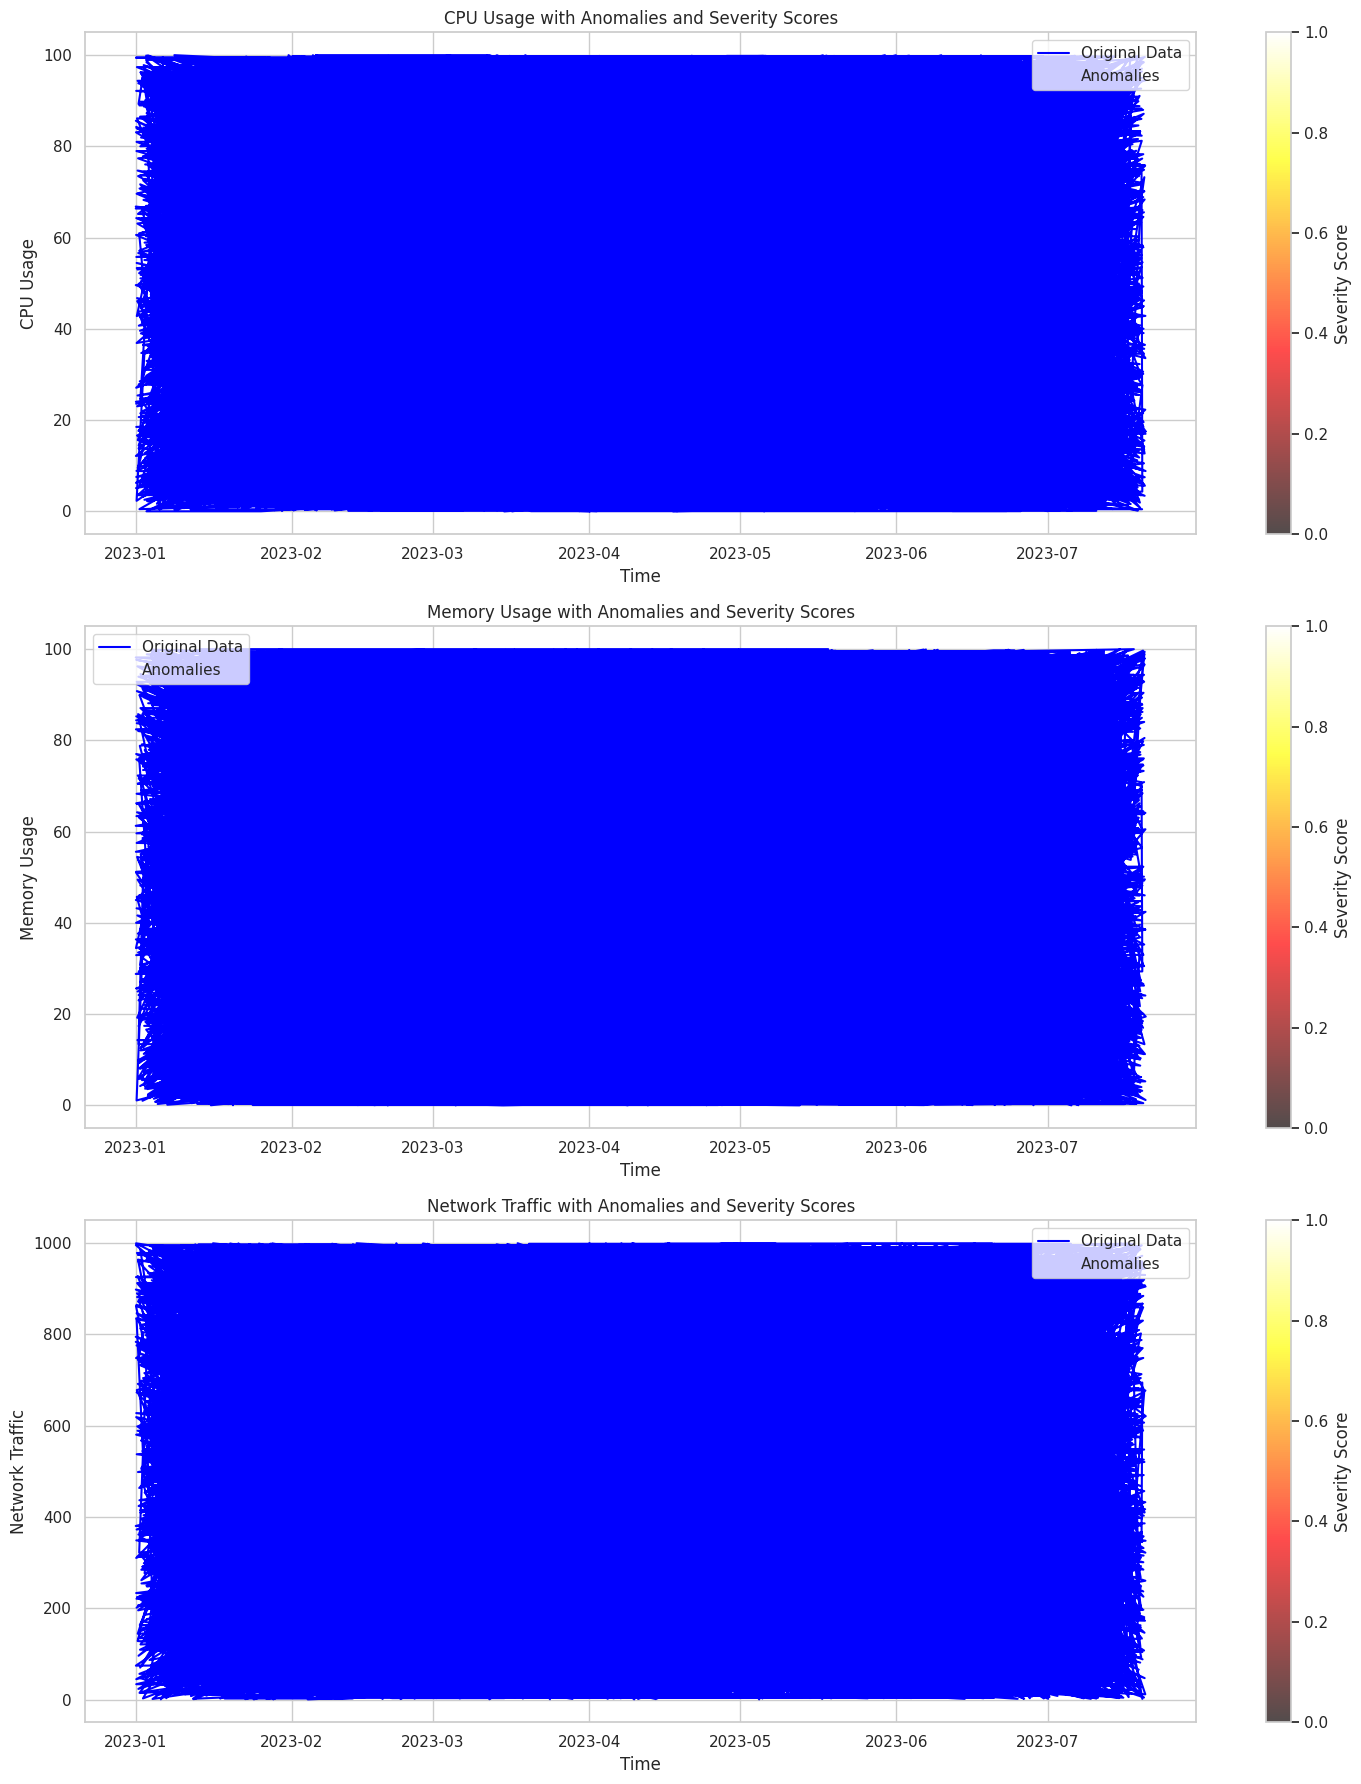

In [16]:
sns.set(style="whitegrid")

def plot_anomalies_with_categories(df, df_anomalies, metric, title):
    plt.figure(figsize=(15,6))
    plt.plot(df[metric], label='Original Data', color='blue')

    for category in df_anomalies[f'{metric}_category'].unique():
        if category:
            plt.scatter(df_anomalies[df_anomalies[f'{metric}_category'] == category].index,
                        df_anomalies[df_anomalies[f'{metric}_category'] == category][metric],
                        label=f'{metric} - {category}', alpha=0.7)

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(metric)
    plt.legend()
    plt.show()

plot_anomalies_with_categories(df_selected, df_anomalies, 'cpu_usage', 'CPU Usage with Anomalies and Categories')
plot_anomalies_with_categories(df_selected, df_anomalies, 'memory_usage', 'Memory Usage with Anomalies and Categories')
plot_anomalies_with_categories(df_selected, df_anomalies, 'network_traffic', 'Network Traffic with Anomalies and Categories')

def plot_anomalies_with_severity(df, df_anomalies, metric, title):
    plt.figure(figsize=(15,6))
    plt.plot(df[metric], label='Original Data', color='blue')

    plt.scatter(df_anomalies.index, df_anomalies[metric],
                c=df_anomalies['severity_score'], cmap='hot',
                label=f'{metric} Anomalies (Severity)', alpha=0.7)

    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(metric)
    plt.colorbar(label='Severity Score')
    plt.legend()
    plt.show()

plot_anomalies_with_severity(df_selected, df_anomalies, 'cpu_usage', 'CPU Usage Anomalies with Severity Scores')
plot_anomalies_with_severity(df_selected, df_anomalies, 'memory_usage', 'Memory Usage Anomalies with Severity Scores')
plot_anomalies_with_severity(df_selected, df_anomalies, 'network_traffic', 'Network Traffic Anomalies with Severity Scores')

def combine_plots(df, df_anomalies):
    plt.figure(figsize=(15,18))

    plt.subplot(3, 1, 1)
    plt.plot(df['cpu_usage'], label='Original Data', color='blue')
    plt.scatter(df_anomalies.index, df_anomalies['cpu_usage'], c=df_anomalies['severity_score'], cmap='hot', label='Anomalies', alpha=0.7)
    plt.title('CPU Usage with Anomalies and Severity Scores')
    plt.xlabel('Time')
    plt.ylabel('CPU Usage')
    plt.colorbar(label='Severity Score')
    plt.legend()

    plt.subplot(3, 1, 2)
    plt.plot(df['memory_usage'], label='Original Data', color='blue')
    plt.scatter(df_anomalies.index, df_anomalies['memory_usage'], c=df_anomalies['severity_score'], cmap='hot', label='Anomalies', alpha=0.7)
    plt.title('Memory Usage with Anomalies and Severity Scores')
    plt.xlabel('Time')
    plt.ylabel('Memory Usage')
    plt.colorbar(label='Severity Score')
    plt.legend()

    plt.subplot(3, 1, 3)
    plt.plot(df['network_traffic'], label='Original Data', color='blue')
    plt.scatter(df_anomalies.index, df_anomalies['network_traffic'], c=df_anomalies['severity_score'], cmap='hot', label='Anomalies', alpha=0.7)
    plt.title('Network Traffic with Anomalies and Severity Scores')
    plt.xlabel('Time')
    plt.ylabel('Network Traffic')
    plt.colorbar(label='Severity Score')
    plt.legend()

    plt.tight_layout()
    plt.show()

combine_plots(df_selected, df_anomalies)


In [17]:
!pip install shap


<ipython-input-18-4b984b2a91ca>:4: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  X = df[['cpu_usage', 'memory_usage', 'network_traffic']].fillna(method='ffill').fillna(method='bfill')
100%|===================| 18741/18812 [03:10<00:00]       

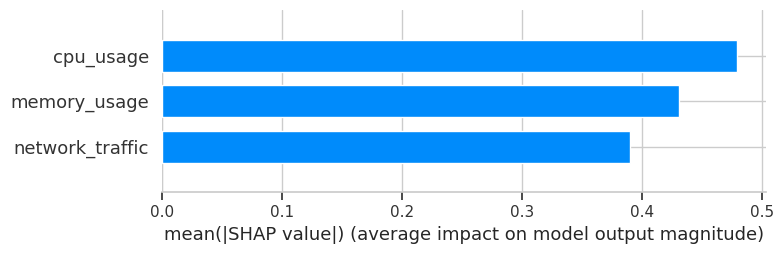

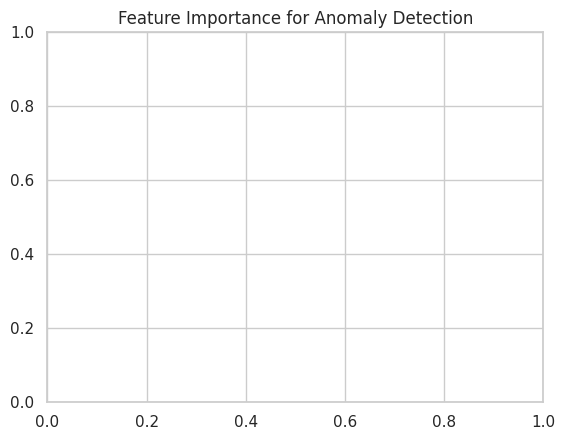

In [18]:
import shap
from sklearn.ensemble import IsolationForest

X = df[['cpu_usage', 'memory_usage', 'network_traffic']].fillna(method='ffill').fillna(method='bfill')
y = df_anomalies['cpu_usage_category']

model = IsolationForest(contamination=0.1, random_state=0)
model.fit(X)

explainer = shap.Explainer(model, X)
shap_values = explainer(X)

plt.figure(figsize=(15, 10))
shap.summary_plot(shap_values, X, plot_type="bar")
plt.title('Feature Importance for Anomaly Detection')
plt.show()

def plot_shap_values_for_anomalies(df_anomalies, shap_values, feature_names):
    for index, row in df_anomalies.iterrows():
        if row['cpu_usage_category'] == 'Spike':
            shap.force_plot(explainer.expected_value, shap_values[index], X.iloc[index], feature_names=feature_names)
            plt.show()

plot_shap_values_for_anomalies(df_anomalies, shap_values, X.columns)
